# 26. Pytorch 0.4.0

https://pytorch.org/2018/04/22/0_4_0-migration-guide.html

## Merging Tensor and Variable

In [1]:
import torch

In [2]:
torch.__version__

'0.4.1'

In [3]:
x = torch.DoubleTensor([1, 1, 1])
x

tensor([1., 1., 1.], dtype=torch.float64)

In [4]:
# Variable도 지원함
from torch.autograd import Variable
Variable(x)

tensor([1., 1., 1.], dtype=torch.float64)

In [5]:
type(x)

torch.Tensor

In [6]:
print(x.type())

torch.DoubleTensor


## Autograd 

In [7]:
x = torch.ones(1)
x.requires_grad

False

In [8]:
y = torch.ones(1)
y.requires_grad

False

In [9]:
z = x + y

In [10]:
z.requires_grad

False

In [11]:
x.requires_grad_()
x.requires_grad

True

In [12]:
z = x + y

In [13]:
z.requires_grad

True

## .detach vs .data

@ .detach된 tensor는 requires_grad가 False이지만 기존 grad에 연동

In [14]:
a = torch.tensor([1,2,3.], requires_grad = True)
out = a.sigmoid()
c = out.detach()
c.zero_()

tensor([0., 0., 0.])

In [15]:
out

tensor([0., 0., 0.], grad_fn=<SigmoidBackward>)

In [16]:
out.sum().backward()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation

@ .data된 tensor는 grad와 연동하지 않음

In [17]:
a = torch.tensor([1,2,3.], requires_grad = True)
out = a.sigmoid()
c = out.data
c.zero_()

tensor([0., 0., 0.])

In [18]:
out

tensor([0., 0., 0.], grad_fn=<SigmoidBackward>)

In [19]:
out.sum().backward()

In [20]:
a.grad

tensor([0., 0., 0.])

## 0-dimensional (scalar) Tensor

In [21]:
torch.tensor(3.1416)

tensor(3.1416)

In [22]:
torch.tensor(3.1416).size()

torch.Size([])

In [23]:
torch.tensor([3]).size()

torch.Size([1])

In [24]:
vector = torch.arange(2, 6)

In [25]:
vector

tensor([2, 3, 4, 5])

In [26]:
vector.size()

torch.Size([4])

In [27]:
vector[3] # indexing into a vector gives a scalar

tensor(5)

In [28]:
vector[3].item() # .item() gives the value as a Python number

5

In [29]:
torch.tensor([2, 3]).sum()

tensor(5)

In [30]:
# total_loss += loss.data[0]
# total_loss += loss.item()

## device & dtype

In [31]:
cuda = torch.device("cuda")

In [32]:
torch.tensor([[1], [2], [3]], dtype=torch.half, device=cuda)

tensor([[1.],
        [2.],
        [3.]], device='cuda:0', dtype=torch.float16)

In [33]:
torch.tensor([1, 2.3]).dtype

torch.float32

In [34]:
torch.tensor([1, 2]).dtype

torch.int64

## torch.*_like

In [35]:
x = torch.randn(3, dtype=torch.float64)

In [36]:
torch.zeros_like(x)

tensor([0., 0., 0.], dtype=torch.float64)

In [37]:
torch.randn_like(x)

tensor([ 0.6241, -0.4575,  0.2404], dtype=torch.float64)

## Summary with CNN

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [41]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=batch_size,
                                         shuffle=False)

In [42]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

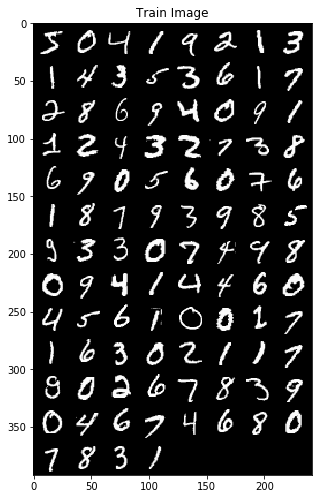

In [43]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [44]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)

        return out

In [45]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [46]:
# model = CNN().cuda()
model = CNN().to(device)

In [47]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [48]:
num_epochs = 5

In [49]:
if os.path.isfile('_.pkl'):
    model.load_state_dict(torch.load('cnn.pkl'))
    print("Model Loaded!")

else:
    
    for epoch in range(num_epochs):

        total_batch = len(mnist_train) // batch_size

        for i, (batch_images, batch_labels) in enumerate(train_loader):

#             X = Variable(batch_images).cuda()
#             Y = Variable(batch_labels).cuda()
            X = batch_images.to(device)
            Y = batch_labels.to(device)

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
#                      %(epoch+1, num_epochs, i+1, total_batch, cost.data[0]))
                     %(epoch+1, num_epochs, i+1, total_batch, cost.item())) 

    if not os.path.isfile('cnn.pkl'):
        print("Model Saved!")
        torch.save(model.state_dict(), 'cnn.pkl')

Epoch [1/5], lter [100/600] Loss: 0.4279
Epoch [1/5], lter [200/600] Loss: 0.2119
Epoch [1/5], lter [300/600] Loss: 0.1668
Epoch [1/5], lter [400/600] Loss: 0.1036
Epoch [1/5], lter [500/600] Loss: 0.1331
Epoch [1/5], lter [600/600] Loss: 0.2712
Epoch [2/5], lter [100/600] Loss: 0.0192
Epoch [2/5], lter [200/600] Loss: 0.0496
Epoch [2/5], lter [300/600] Loss: 0.0324
Epoch [2/5], lter [400/600] Loss: 0.0311
Epoch [2/5], lter [500/600] Loss: 0.0794
Epoch [2/5], lter [600/600] Loss: 0.2442
Epoch [3/5], lter [100/600] Loss: 0.0095
Epoch [3/5], lter [200/600] Loss: 0.0281
Epoch [3/5], lter [300/600] Loss: 0.0173
Epoch [3/5], lter [400/600] Loss: 0.0318
Epoch [3/5], lter [500/600] Loss: 0.0600
Epoch [3/5], lter [600/600] Loss: 0.2257
Epoch [4/5], lter [100/600] Loss: 0.0074
Epoch [4/5], lter [200/600] Loss: 0.0172
Epoch [4/5], lter [300/600] Loss: 0.0090
Epoch [4/5], lter [400/600] Loss: 0.0137
Epoch [4/5], lter [500/600] Loss: 0.0562
Epoch [4/5], lter [600/600] Loss: 0.2109
Epoch [5/5], lte

In [50]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
#     images = Variable(images).cuda()
    images = images.to(device)
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
#     correct += (predicted == labels.cuda()).sum()
    correct += (predicted == labels.to(device)).sum()
    
correct = correct.cpu().numpy()    
print('correct :', correct)
print('total   :', total)
print('Accuracy of test images: %f' % (100 * correct / total))

correct : 9876
total   : 10000
Accuracy of test images: 98.760000
